# Coefficient field inversion in an elliptic partial differential equation

We consider the estimation of a coefficient in an elliptic partial differential equation as a first model problem.
Depending on the interpretation of the unknowns and the type of measurements, this model problem arises, for instance, in electrical impedence tomography.

Let $\Omega\subset\mathbb{R}^n$, $n\in\{1,2,3\}$ be an open, bounded
domain and consider the following problem:

$$
\min_{m} J(m):=\frac{1}{2}\int_{\Omega} (u-d)^2\, dx + \gamma\int_\Omega\sqrt{|\nabla m|^2+\beta}\,dx,
$$

where $u$ is the solution of

$$
\begin{split}
\quad -\nabla\cdot(e^m \nabla u) &= 0 \text{ in }\Omega,\\
e^m \nabla u &= j \text{ on }\partial\Omega.
\end{split}
$$

Here $m \in \mathcal{M}:=\{m\in L^{\infty}(\Omega) \bigcap H^1(\Omega)\}$ denotes the unknown parameter field, 
$u \in \mathcal{V}:= \left\{v \in H^1(\Omega) | v(\boldsymbol{x}_c) = 0 \text{ for a given point } \boldsymbol{x}_c\in \Omega \right\}$ the state variable, $d$ the (possibly noisy) data, $j\in H^{-1/2}(\partial\Omega)$ a given boundary force, and $\gamma\ge 0$ the regularization parameter.

### The variational (or weak) form of the forward problem:

Find $u\in \mathcal{V}$ such that 

$$ \int_{\Omega}e^m \nabla u \cdot \nabla \tilde{p} \, dx - \int_{\partial \Omega} j \tilde{p} \,dx = 0, \text{ for all } \tilde{p}\in \mathcal{V}.$$


### Gradient evaluation:

The Lagrangian functional $\mathscr{L}:\mathcal{V}\times\mathcal{M}\times\mathcal{V}\rightarrow \mathbb{R}$ is given by

$$
\mathscr{L}(u,m,p):= \frac{1}{2}\int_{\Omega}(u-u_d)^2 dx +
\frac{\gamma}{2}\int_\Omega \sqrt{|\nabla m|^2+\beta} dx +  \int_{\Omega} e^m\nabla u \cdot \nabla p dx 
- \int_{\partial \Omega} j\,p\, dx.
$$

Then the gradient of the cost functional $\mathcal{J}(m)$ with respect to the parameter $m$ in an arbitrary direction $\tilde m$ is

$$
    (\mathcal{G}(m), \tilde m) := \mathscr{L}_m(u,m,p)(\tilde{m}) = \gamma \int_\Omega \frac{\nabla m}{\sqrt{|\nabla m|^2+\beta}} \cdot \nabla \tilde{m}\, dx +
     \int_\Omega \tilde{m}e^m\nabla u \cdot \nabla p\, dx \quad \forall \tilde{m} \in \mathcal{M},
$$

where $u \in \mathcal{V}$ is the solution of the forward problem,

$$ (\mathscr{L}_p(u,m,p), \tilde{p})  := \int_{\Omega}e^m\nabla u \cdot \nabla \tilde{p}\, dx - \int_{\partial\Omega} j\,\tilde{p}\, dx = 0
\quad \forall \tilde{p} \in \mathcal{V}, $$

and $p \in \mathcal{V}$ is the solution of the adjoint problem,

$$ (\mathscr{L}_u(u,m,p), \tilde{u}) := \int_{\Omega} e^m\nabla p \cdot \nabla \tilde{u}\, dx + \int_{\Omega} (u-d)\tilde{u}\,dx = 0
\quad \forall \tilde{u} \in \mathcal{V}.$$

### Steepest descent method.

Written in abstract form, the steepest descent methods computes an update direction $\hat{m}_k$ in the direction of the negative gradient defined as 

$$
\int_\Omega \hat{m}_k \tilde{m}\, dx = -\left(\mathcal{G}(m_k), \tilde m\right) \quad \forall \tilde{m} \in \mathcal{M},
$$

where the evaluation of the gradient $\mathcal{G}(m_k)$ involve the solution $u_k$ and $p_k$ of the forward and adjoint problem (respectively) for $m = m_k$.

Then we set $m_{k+1} = m_k + \alpha \hat{m}_k$, where the step length $\alpha$ is chosen to guarantee sufficient descent. 


### Goals:

By the end of this notebook, you should be able to:

- solve the forward and adjoint Poisson equations
- understand the inverse method framework
- visualise and understand the results
- modify the problem and code

### Mathematical tools used:

- Finite element method
- Derivation of gradient via the adjoint method
- Armijo line search

### Import dependencies

In [1]:
from __future__ import print_function, division, absolute_import

import matplotlib.pyplot as plt
%matplotlib inline

import dolfin as dl
from hippylib import nb

import numpy as np
import logging


logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

### Model set up:

As in the introduction, the first thing we need to do is to set up the numerical model.

In this cell, we set the mesh ``mesh``, the finite element spaces ``Vm`` and ``Vu`` corresponding to the parameter space and state/adjoint space, respectively. In particular, we use linear finite elements for the parameter space, and quadratic elements for the state/adjoint space.

The true parameter ``mtrue`` is the finite element interpolant of the function

$$ m_{\rm true} = \left\{ \begin{array}{l} \ln 4 \; \forall \,(x,y) \, {\rm s.t.}\, \sqrt{ (x-.5)^2 + (y-.5)^2} \leq 0.2 \\ \ln 8 \; {\rm otherwise}. \end{array}\right. $$

The forcing term ``j`` for the forward problem is

$$ j(x,y) = (x - 0.5)y(y-1) \; \forall {\boldsymbol{x}=(x,y)} \in \partial\Omega. $$

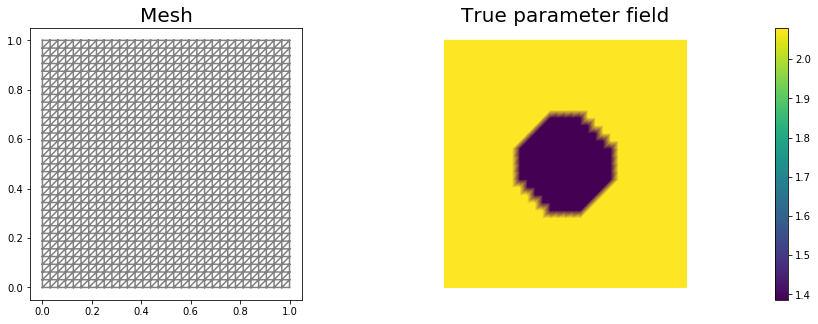

In [2]:
# create mesh and define function spaces
nx = 32
ny = 32
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

# The true and initial guess for inverted parameter
mtrue = dl.interpolate(dl.Expression('std::log( 8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) ) )', degree=5), Vm)

# define function for state and adjoint
u = dl.Function(Vu)
m = dl.Function(Vm)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

# initialize input functions
j  = dl.Expression("(x[0]-.5)*x[1]*(x[1]-1)", degree=3)

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh, subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue, subplot_loc=122, mytitle="True parameter field")
plt.show()

In [3]:
# Fix the value of the state at the center of the domain
def d_boundary(x,on_boundary):
    return dl.near(x[0], .5) and dl.near(x[1], .5)

u0 = dl.Constant(0.)
bc_state = dl.DirichletBC(Vu, u0, d_boundary, "pointwise")
bc_adj   = dl.DirichletBC(Vu, dl.Constant(0.), d_boundary, "pointwise")

### Set up synthetic observations (inverse crime):

To generate the synthetic observation we first solve the PDE for the state variable ``utrue`` corresponding to the true parameter ``mtrue``.
Specifically, we solve the variational problem

Find $u\in \mathcal{V}$ such that 

$$\underbrace{\int_\Omega e^{m_{\text true}} \nabla u \cdot \nabla v \, dx}_{\; := \; a_{\rm true}} - \underbrace{\int_{\partial\Omega} j\,v\,dx}_{\; := \;L_{\rm true}} = 0, \text{ for all } v\in \mathcal{V}$$.

Then we perturb the true state variable and write the observation ``d`` as

$$ d = u_{\rm true} + \eta, \quad {\rm where} \; \eta \sim \mathcal{N}(0, \sigma^2).$$

Here the standard variation $\sigma$ is proportional to ``noise_level``.

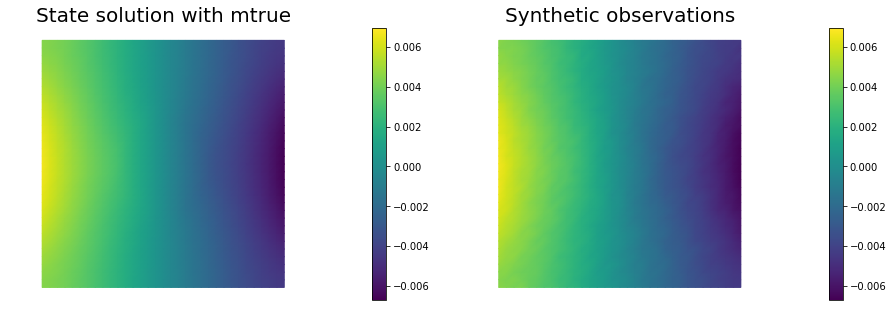

In [4]:
# noise level
noise_level = 0.01

# weak form for setting up the synthetic observations
a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_true = j * u_test * dl.ds

# solve the forward/state problem to generate synthetic observations
A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

utrue = dl.Function(Vu)
dl.solve(A_true, utrue.vector(), b_true)

d = dl.Function(Vu)
d.assign(utrue)

# perturb state solution and create synthetic measurements d
# d = u + ||u||/SNR * random.normal
MAX = d.vector().norm("linf")
noise = dl.Vector()
A_true.init_vector(noise,1)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(d.vector().get_local())) )
bc_adj.apply(noise)

d.vector().axpy(1., noise)

# plot
nb.multi1_plot([utrue, d], ["State solution with mtrue", "Synthetic observations"])
plt.show()

### The cost functional evaluation:

$$
J(m):=\underbrace{\frac{1}{2}\int_\Omega (u-d)^2\, dx}_{\text misfit} + \underbrace{\frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx}_{\text reg}
$$

In [5]:
# Regularization parameter
gamma = 1e-9
beta  = 0.1

# Define cost function
def cost(u, d, m, gamma, beta):
    reg = 0.5*dl.assemble( dl.sqrt(dl.inner(dl.grad(m), dl.grad(m))+dl.Constant(beta))*dl.dx ) 
    misfit = 0.5 * dl.assemble( (u-d)**2*dl.dx)
    return [gamma*reg + misfit, misfit, reg]

### Setting up the variational form for the state/adjoint equations and gradient evaluation

Below we define the variational forms that appears in the the state/adjoint equations and gradient evaluations.

Specifically,

- `a_state`, `L_state` stand for the bilinear and linear form of the state equation, repectively;
- `a_adj`, `L_adj` stand for the bilinear and linear form of the adjoint equation, repectively;
- `grad_misfit`, `grad_reg` stand for the contributions to the gradient coming from the data misfit and the regularization, respectively.

We also build the *mass* matrix $M$ that is used to discretize the $L^2(\Omega)$ inner product.

In [6]:
# weak form for setting up the state equation
a_state = dl.inner( dl.exp(m) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_state = j * u_test * dl.ds

# weak form for setting up the adjoint equations
a_adj = dl.inner( dl.exp(m) * dl.grad(p_trial), dl.grad(p_test) ) * dl.dx
L_adj = - dl.inner(u - d, p_test) * dl.dx

# weak form for gradient
grad_misfit = dl.inner(dl.exp(m)*m_test*dl.grad(u), dl.grad(p)) * dl.dx
grad_reg    = (dl.Constant(gamma)/dl.sqrt(dl.inner(dl.grad(m), dl.grad(m))+dl.Constant(beta))
               *dl.inner(dl.grad(m), dl.grad(m_test)))*dl.dx

# Mass matrix in parameter space
Mvarf    = dl.inner(m_trial, m_test) * dl.dx
M = dl.assemble(Mvarf)

### Finite difference check of the gradient

We use a **finite difference check** to verify that our gradient derivation is correct.
Specifically, we consider a function $ m_0\in \mathcal{M}$ and we verify that for an arbitrary direction $\tilde{m} \in \mathcal{M}$ we have
$$ r := \left| \frac{ \mathcal{J}(m_0 + \varepsilon \tilde{m}) - \mathcal{J}(m_0)}{\varepsilon} -  \left(\mathcal{G}(m_0), \tilde{m}\right)\right| = \mathcal{O}(\varepsilon).$$

In the figure below we show in a loglog scale the value of $r$ as a function of $\varepsilon$. We observe that $r$ decays linearly for a wide range of values of $\varepsilon$, however we notice an increase in the error for extremely small values of $\varepsilon$ due to numerical stability and finite precision arithmetic.


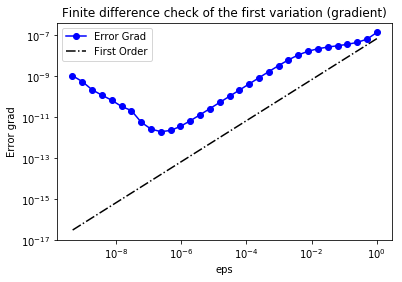

In [7]:
m0 = dl.interpolate(dl.Constant(np.log(4.) ), Vm )

n_eps = 32
eps = np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m.assign(m0)

#Solve the fwd problem and evaluate the cost functional
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

c0, _, _ = cost(u, d, m, gamma, beta)

# Solve the adjoint problem and evaluate the gradient
adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
dl.solve(adj_A, p.vector(), adjoint_RHS)

# evaluate the  gradient
grad0 = dl.assemble(grad_misfit + grad_reg)

# Define an arbitrary direction m_hat to perform the check 
mtilde = dl.Function(Vm).vector()
mtilde.set_local(np.random.randn(Vm.dim()))
mtilde.apply("")
mtilde_grad0 = grad0.inner(mtilde)

for i in range(n_eps):
    m.assign(m0)
    m.vector().axpy(eps[i], mtilde)
    
    A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve(A, u.vector(), state_b)

    cplus, _, _ = cost(u, d, m, gamma, beta)
   
    err_grad[i] = abs( (cplus - c0)/eps[i] - mtilde_grad0 )

plt.figure()    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the first variation (gradient)")
plt.xlabel("eps")
plt.ylabel("Error grad")
plt.legend(loc = "upper left")
plt.show()

### Initial guess

We solve the state equation and compute the cost functional for the initial guess of the parameter ``m0``

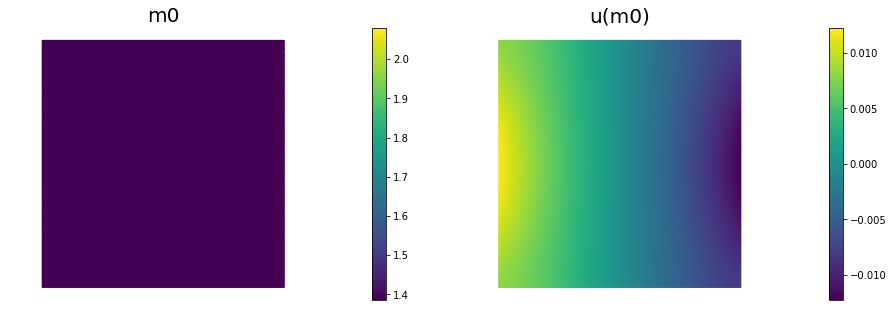

In [8]:
m.assign(m0)

# solve state equation
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

# evaluate cost
[cost_old, misfit_old, reg_old] = cost(u, d, m, gamma, beta)

# plot
plt.figure(figsize=(15,5))
nb.plot(m,subplot_loc=121, mytitle="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
nb.plot(u,subplot_loc=122, mytitle="u(m0)")
plt.show()

## The steepest descent with Armijo line search:

We solve the constrained optimization problem using the steepest descent method with Armijo line search.

The stopping criterion is based on a relative reduction of the norm of the gradient (i.e. $\frac{\|g_{n}\|}{\|g_{0}\|} \leq \tau$).

The gradient is computed by solving the state and adjoint equation for the current parameter $m$, and then substituing the current state $u$, parameter $m$ and adjoint $p$ variables in the weak form expression of the gradient:

$$ (g, \tilde{m}) = \gamma(\nabla m, \nabla \tilde{m}) +(\tilde{m}e^m\nabla u, \nabla p).$$

The Armijo line search uses backtracking to find $\alpha$ such that a sufficient reduction in the cost functional is achieved.
Specifically, we use backtracking to find $\alpha$ such that:

$$J( m - \alpha g ) \leq J(m) - \alpha c_{\rm armijo} (g,g). $$


Nit  cost          misfit        reg         ||grad||       alpha  N backtrack
  0   2.97653e-06   2.97418e-06   2.34912e+00   1.72104e-05   1.00000e+05     0


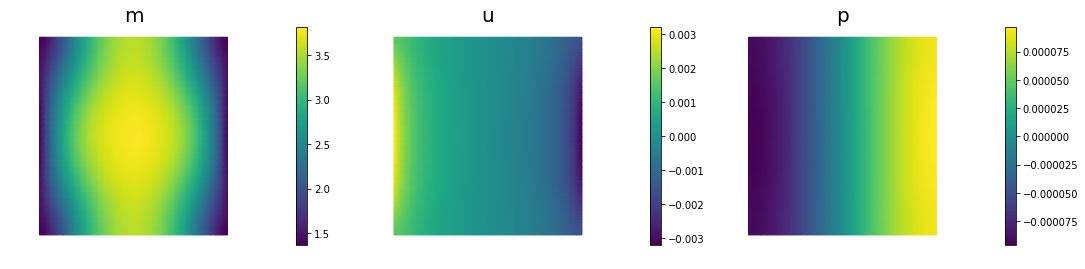

 10   2.83599e-08   2.74945e-08   8.65348e-01   3.66732e-07   1.00000e+05     0
 20   8.48402e-09   7.54907e-09   9.34957e-01   1.34908e-07   1.00000e+05     0
 30   5.24650e-09   4.31496e-09   9.31538e-01   8.31755e-08   5.00000e+04     1
 40   4.37635e-09   3.45851e-09   9.17837e-01   7.22478e-08   5.00000e+04     1
 50   3.82313e-09   2.93491e-09   8.88229e-01   1.01944e-07   2.50000e+04     2


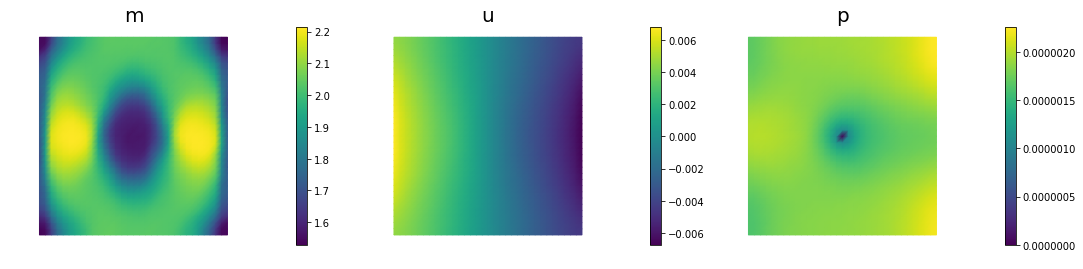

 60   3.53842e-09   2.66684e-09   8.71579e-01   3.41120e-08   1.00000e+05     0
 70   3.25805e-09   2.42496e-09   8.33094e-01   3.79071e-08   5.00000e+04     1
 80   3.06897e-09   2.26094e-09   8.08033e-01   4.36116e-08   2.50000e+04     2
 90   2.92647e-09   2.13226e-09   7.94217e-01   3.74183e-08   5.00000e+04     1
100   2.80312e-09   2.02808e-09   7.75040e-01   2.68689e-08   5.00000e+04     1


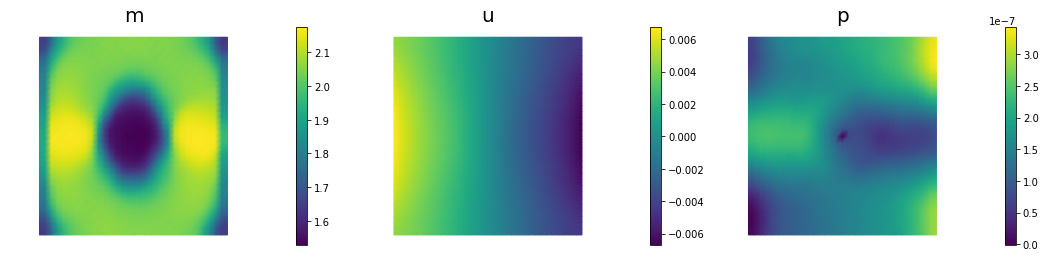

110   2.70880e-09   1.94750e-09   7.61307e-01   2.57845e-08   5.00000e+04     1
120   2.62856e-09   1.88032e-09   7.48241e-01   2.54813e-08   5.00000e+04     1
130   2.55913e-09   1.82362e-09   7.35506e-01   2.54362e-08   5.00000e+04     1
140   2.49370e-09   1.77762e-09   7.16077e-01   2.55065e-08   2.50000e+04     2
150   2.44259e-09   1.73835e-09   7.04242e-01   2.45785e-08   2.50000e+04     2


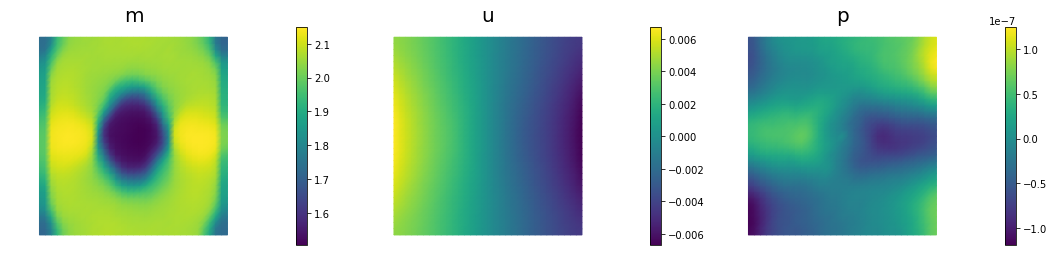

160   2.40161e-09   1.70420e-09   6.97409e-01   2.04518e-08   5.00000e+04     1
170   2.35919e-09   1.67627e-09   6.82919e-01   3.79875e-08   2.50000e+04     2
180   2.32351e-09   1.65150e-09   6.72001e-01   2.46849e-08   2.50000e+04     2
190   2.29487e-09   1.62949e-09   6.65381e-01   1.78369e-08   5.00000e+04     1
200   2.26424e-09   1.61124e-09   6.53004e-01   2.40013e-08   2.50000e+04     2


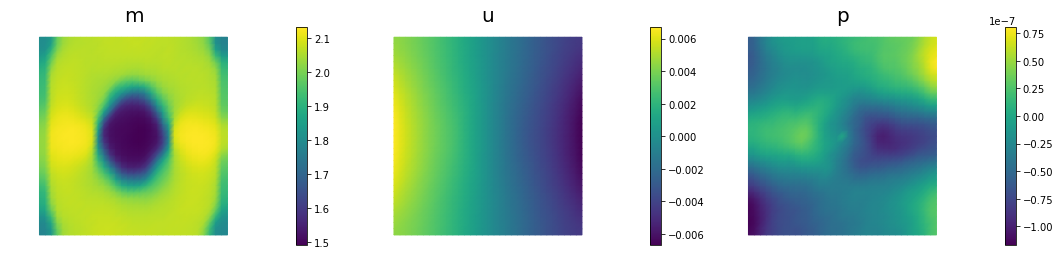

210   2.23854e-09   1.59478e-09   6.43757e-01   1.78049e-08   2.50000e+04     2
220   2.21646e-09   1.57873e-09   6.37731e-01   1.60627e-08   5.00000e+04     1
230   2.19485e-09   1.56535e-09   6.29501e-01   1.57423e-08   5.00000e+04     1
240   2.17496e-09   1.55320e-09   6.21757e-01   1.56540e-08   5.00000e+04     1
250   2.15475e-09   1.54303e-09   6.11725e-01   1.67641e-08   2.50000e+04     2


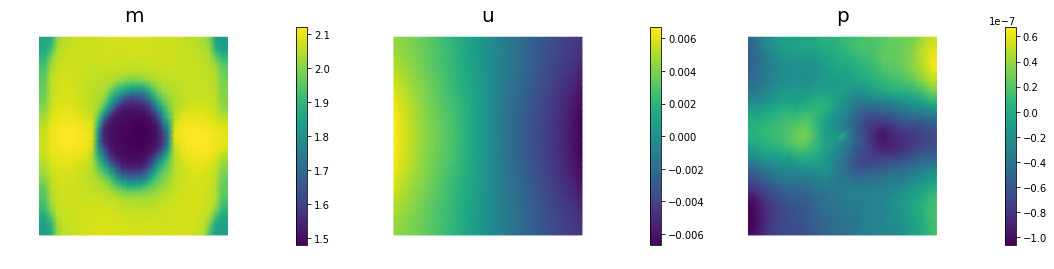

260   2.13788e-09   1.53285e-09   6.05028e-01   2.18042e-08   2.50000e+04     2
270   2.12369e-09   1.52353e-09   6.00159e-01   1.37483e-08   5.00000e+04     1
280   2.10770e-09   1.51564e-09   5.92064e-01   1.62921e-08   2.50000e+04     2
290   2.09544e-09   1.50765e-09   5.87793e-01   1.22513e-08   5.00000e+04     1
300   2.08206e-09   1.50082e-09   5.81244e-01   1.70647e-08   2.50000e+04     2


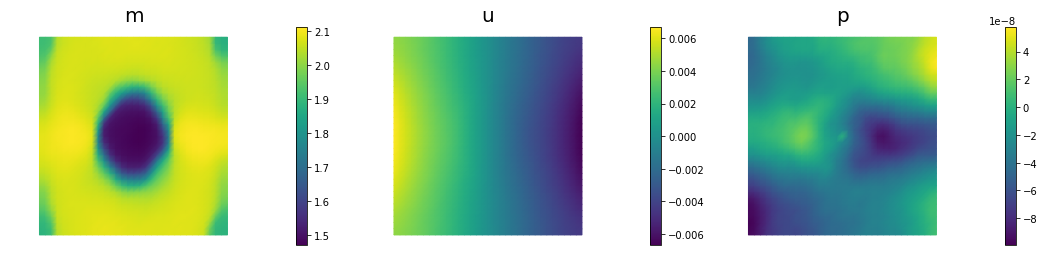

310   2.07071e-09   1.49442e-09   5.76292e-01   1.25488e-08   2.50000e+04     2
320   2.05998e-09   1.48787e-09   5.72113e-01   1.92742e-08   2.50000e+04     2
330   2.04995e-09   1.48225e-09   5.67705e-01   1.31665e-08   2.50000e+04     2
340   2.04166e-09   1.47649e-09   5.65175e-01   1.08417e-08   5.00000e+04     1
350   2.03212e-09   1.47152e-09   5.60599e-01   1.74173e-08   2.50000e+04     2


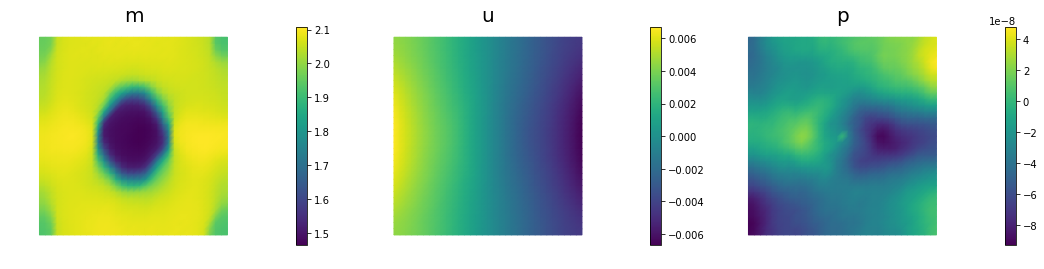

360   2.02398e-09   1.46684e-09   5.57142e-01   1.31733e-08   2.50000e+04     2
370   2.01648e-09   1.46242e-09   5.54058e-01   1.08700e-08   2.50000e+04     2
380   2.01007e-09   1.45788e-09   5.52193e-01   9.37884e-09   5.00000e+04     1
390   2.00280e-09   1.45396e-09   5.48844e-01   1.61595e-08   2.50000e+04     2
400   1.99652e-09   1.45026e-09   5.46256e-01   1.32771e-08   2.50000e+04     2


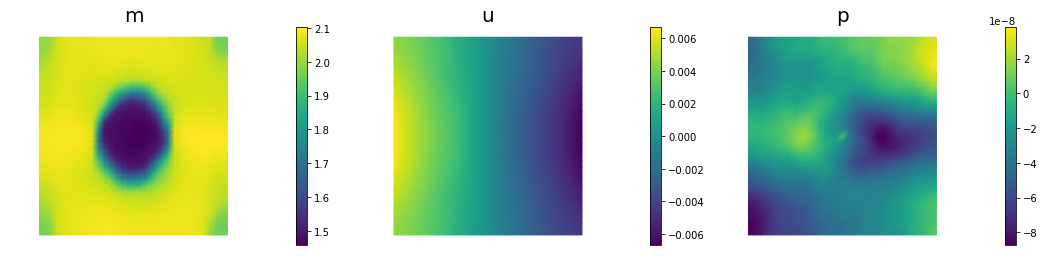

410   1.99069e-09   1.44678e-09   5.43907e-01   1.16109e-08   2.50000e+04     2
420   1.98525e-09   1.44351e-09   5.41735e-01   1.04000e-08   2.50000e+04     2
430   1.98016e-09   1.44044e-09   5.39726e-01   9.45814e-09   2.50000e+04     2
440   1.97543e-09   1.43755e-09   5.37878e-01   8.66872e-09   2.50000e+04     2
450   1.97105e-09   1.43485e-09   5.36200e-01   8.00414e-09   2.50000e+04     2


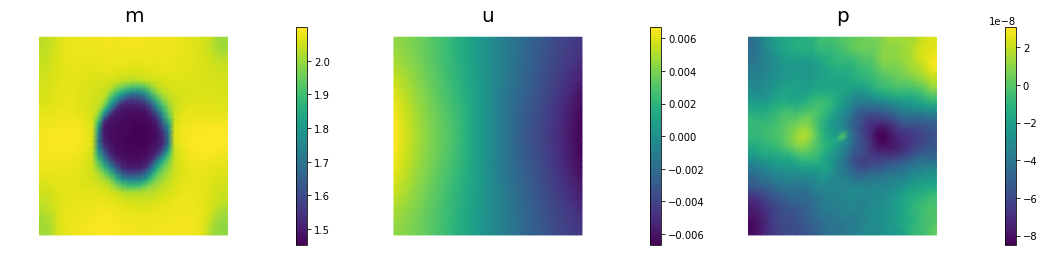

460   1.96702e-09   1.43230e-09   5.34713e-01   7.68867e-09   2.50000e+04     2
470   1.96333e-09   1.42991e-09   5.33417e-01   7.50533e-09   2.50000e+04     2
480   1.95998e-09   1.42766e-09   5.32323e-01   7.48424e-09   2.50000e+04     2
490   1.95700e-09   1.42554e-09   5.31454e-01   8.26411e-09   2.50000e+04     2
500   1.95441e-09   1.42354e-09   5.30866e-01   1.09115e-08   2.50000e+04     2


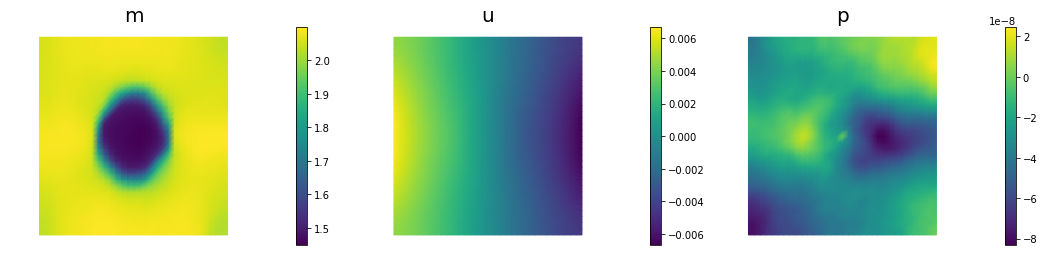

510   1.95197e-09   1.42183e-09   5.30142e-01   6.13094e-09   2.50000e+04     2
520   1.95012e-09   1.42005e-09   5.30062e-01   5.05993e-09   5.00000e+04     1
530   1.94800e-09   1.41853e-09   5.29465e-01   6.68614e-09   2.50000e+04     2
540   1.94635e-09   1.41710e-09   5.29243e-01   5.81951e-09   2.50000e+04     2
550   1.94487e-09   1.41575e-09   5.29119e-01   5.67931e-09   2.50000e+04     2


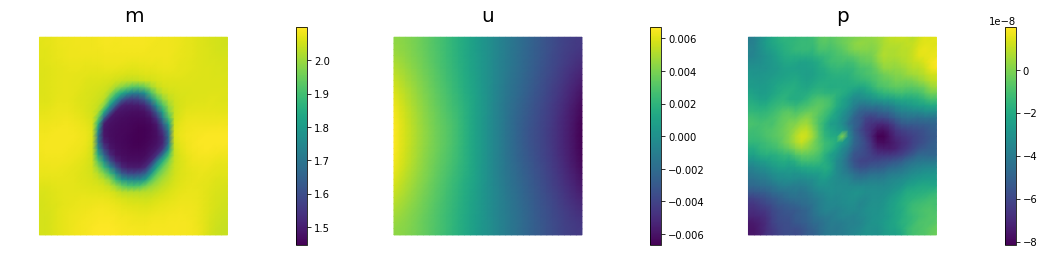

560   1.94355e-09   1.41448e-09   5.29063e-01   5.79343e-09   2.50000e+04     2
570   1.94234e-09   1.41329e-09   5.29058e-01   5.99647e-09   2.50000e+04     2
580   1.94125e-09   1.41216e-09   5.29093e-01   6.21818e-09   2.50000e+04     2
590   1.94026e-09   1.41110e-09   5.29159e-01   6.42803e-09   2.50000e+04     2
600   1.93935e-09   1.41010e-09   5.29248e-01   6.61400e-09   2.50000e+04     2


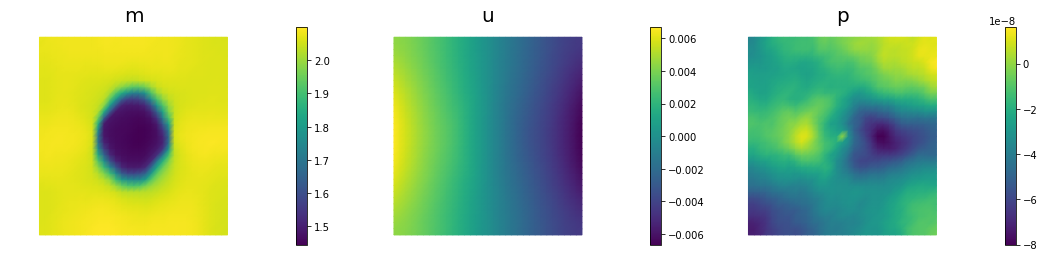

610   1.93851e-09   1.40915e-09   5.29355e-01   6.77530e-09   2.50000e+04     2
620   1.93774e-09   1.40826e-09   5.29477e-01   6.91908e-09   2.50000e+04     2
630   1.93703e-09   1.40742e-09   5.29609e-01   7.05884e-09   2.50000e+04     2
640   1.93637e-09   1.40662e-09   5.29750e-01   7.21393e-09   2.50000e+04     2
650   1.93576e-09   1.40587e-09   5.29898e-01   7.40819e-09   2.50000e+04     2


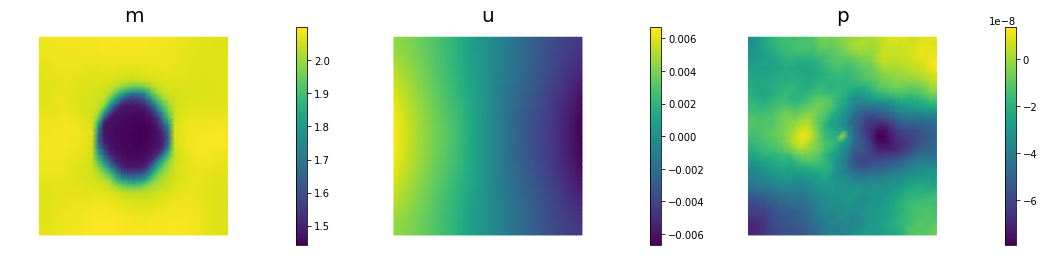

660   1.93520e-09   1.40515e-09   5.30053e-01   7.66265e-09   2.50000e+04     2
670   1.93469e-09   1.40447e-09   5.30213e-01   7.97897e-09   2.50000e+04     2
680   1.93420e-09   1.40383e-09   5.30376e-01   8.32544e-09   2.50000e+04     2
690   1.93375e-09   1.40322e-09   5.30538e-01   8.65005e-09   2.50000e+04     2
700   1.93333e-09   1.40263e-09   5.30696e-01   8.91427e-09   2.50000e+04     2


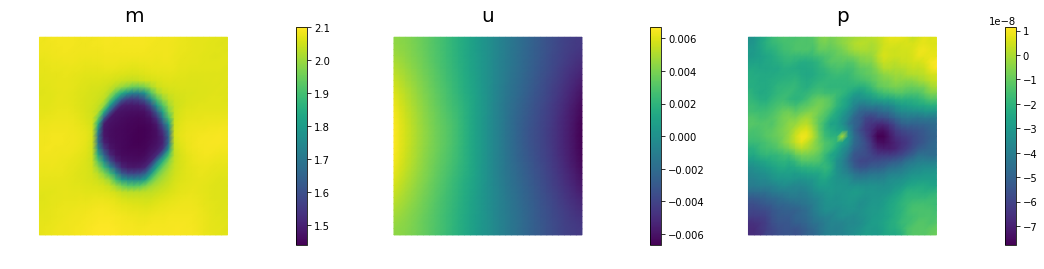

710   1.93293e-09   1.40208e-09   5.30849e-01   9.10925e-09   2.50000e+04     2
720   1.93255e-09   1.40155e-09   5.30996e-01   9.24621e-09   2.50000e+04     2
730   1.93218e-09   1.40105e-09   5.31138e-01   9.34172e-09   2.50000e+04     2
740   1.93184e-09   1.40056e-09   5.31276e-01   9.40992e-09   2.50000e+04     2
750   1.93151e-09   1.40010e-09   5.31410e-01   9.46068e-09   2.50000e+04     2


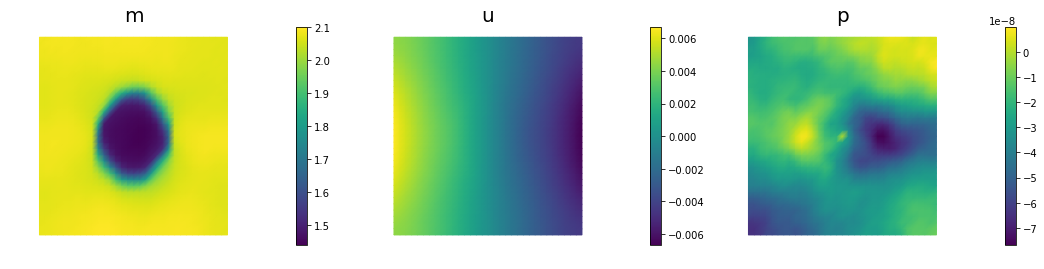

760   1.93120e-09   1.39966e-09   5.31540e-01   9.50033e-09   2.50000e+04     2
770   1.93091e-09   1.39924e-09   5.31666e-01   9.53277e-09   2.50000e+04     2
780   1.93063e-09   1.39884e-09   5.31789e-01   9.56035e-09   2.50000e+04     2
790   1.93036e-09   1.39845e-09   5.31908e-01   9.58455e-09   2.50000e+04     2
800   1.93011e-09   1.39808e-09   5.32023e-01   9.60627e-09   2.50000e+04     2


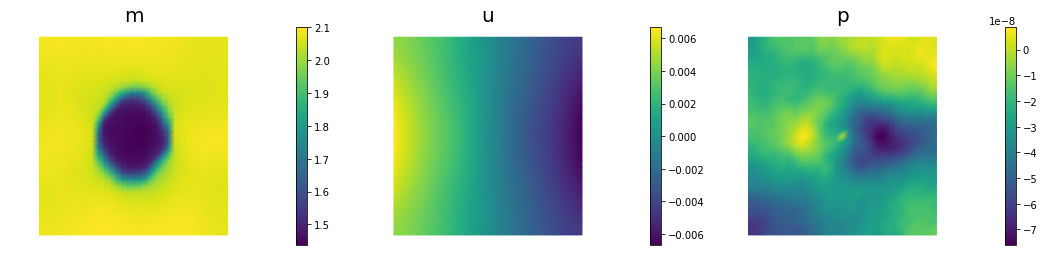

810   1.92986e-09   1.39773e-09   5.32135e-01   9.62611e-09   2.50000e+04     2
820   1.92963e-09   1.39739e-09   5.32244e-01   9.64449e-09   2.50000e+04     2
830   1.92941e-09   1.39706e-09   5.32349e-01   9.66170e-09   2.50000e+04     2
840   1.92919e-09   1.39674e-09   5.32451e-01   9.67793e-09   2.50000e+04     2
850   1.92899e-09   1.39644e-09   5.32550e-01   9.69337e-09   2.50000e+04     2


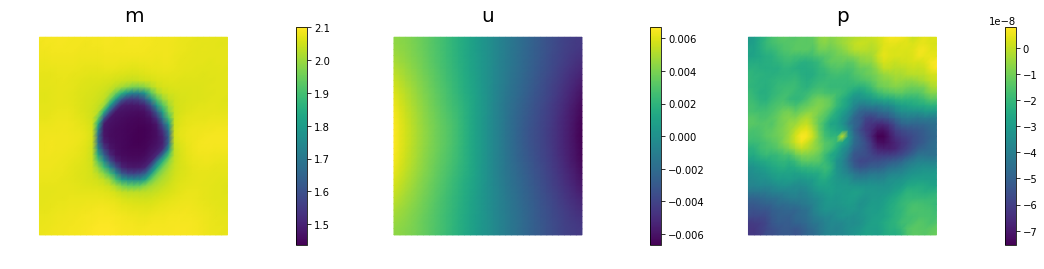

860   1.92879e-09   1.39615e-09   5.32646e-01   9.70813e-09   2.50000e+04     2
870   1.92860e-09   1.39586e-09   5.32739e-01   9.72231e-09   2.50000e+04     2
880   1.92842e-09   1.39559e-09   5.32830e-01   9.73600e-09   2.50000e+04     2
890   1.92825e-09   1.39533e-09   5.32918e-01   9.74925e-09   2.50000e+04     2
900   1.92808e-09   1.39508e-09   5.33003e-01   9.76213e-09   2.50000e+04     2


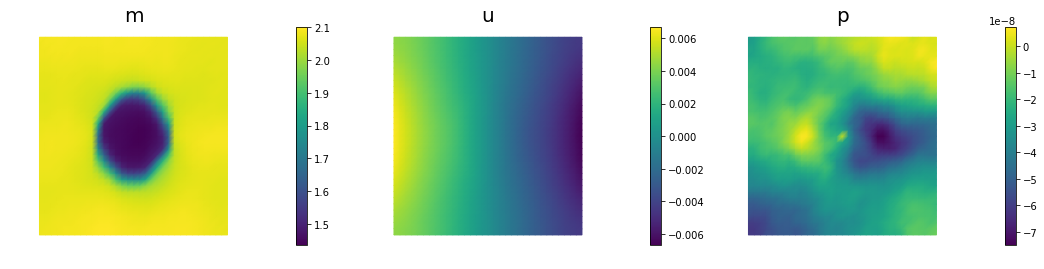

910   1.92792e-09   1.39483e-09   5.33085e-01   9.77467e-09   2.50000e+04     2
920   1.92776e-09   1.39460e-09   5.33165e-01   9.78691e-09   2.50000e+04     2
930   1.92761e-09   1.39437e-09   5.33243e-01   9.79888e-09   2.50000e+04     2
940   1.92747e-09   1.39415e-09   5.33319e-01   9.81060e-09   2.50000e+04     2
950   1.92733e-09   1.39394e-09   5.33392e-01   9.82209e-09   2.50000e+04     2


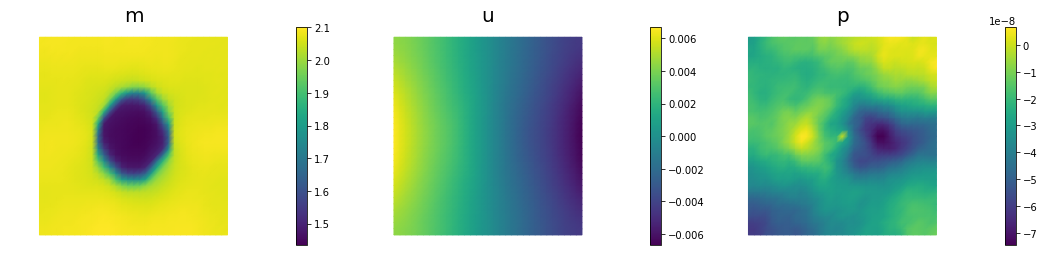

960   1.92720e-09   1.39373e-09   5.33464e-01   9.83336e-09   2.50000e+04     2
970   1.92707e-09   1.39353e-09   5.33533e-01   9.84443e-09   2.50000e+04     2
980   1.92694e-09   1.39334e-09   5.33601e-01   9.85530e-09   2.50000e+04     2
990   1.92682e-09   1.39315e-09   5.33666e-01   9.86599e-09   2.50000e+04     2
Steepest descent did not converge in  1000  iterations


In [9]:
# define parameters for the optimization
tol = 1e-4
maxiter = 1000
print_any = 10
plot_any = 50
c_armijo = 1e-5

# initialize iter counters
iter = 0
converged = False

# initializations
g = dl.Vector()
M.init_vector(g,0)

m_prev = dl.Function(Vm)

print( "Nit  cost          misfit        reg         ||grad||       alpha  N backtrack" )

while iter <  maxiter and not converged:

    # solve the adoint problem
    adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
    dl.solve(adj_A, p.vector(), adjoint_RHS)

    # evaluate the  gradient
    MG = dl.assemble(grad_misfit + grad_reg)
    dl.solve(M, g, MG)

    # calculate the norm of the gradient
    grad_norm2 = g.inner(MG)
    gradnorm = np.sqrt(grad_norm2)
    
    if iter == 0:
        gradnorm0 = gradnorm

    # linesearch
    it_backtrack = 0
    m_prev.assign(m)
    alpha = 1.e5
    backtrack_converged = False
    for it_backtrack in range(20):
        
        m.vector().axpy(-alpha, g )

        # solve the forward problem
        state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
        dl.solve(state_A, u.vector(), state_b)

        # evaluate cost
        [cost_new, misfit_new, reg_new] = cost(u, d, m, gamma, beta)

        # check if Armijo conditions are satisfied
        if cost_new < cost_old - alpha * c_armijo * grad_norm2:
            cost_old = cost_new
            backtrack_converged = True
            break
        else:
            alpha *= 0.5
            m.assign(m_prev)  # reset m
            
    if backtrack_converged == False:
        print( "Backtracking failed. A sufficient descent direction was not found" )
        converged = False
        break

    sp = ""
    if (iter % print_any)== 0 :
        print( "%3d %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %3d" % \
            (iter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
            gradnorm, sp, alpha, sp, it_backtrack) )

    if (iter % plot_any)== 0 :
        nb.multi1_plot([m,u,p], ["m","u","p"], same_colorbar=False)
        plt.show()
    
    # check for convergence
    if gradnorm < tol*gradnorm0 and iter > 0:
        converged = True
        print ("Steepest descent converged in ",iter,"  iterations")
        
    iter += 1
    
if not converged:
    print ( "Steepest descent did not converge in ", maxiter, " iterations")

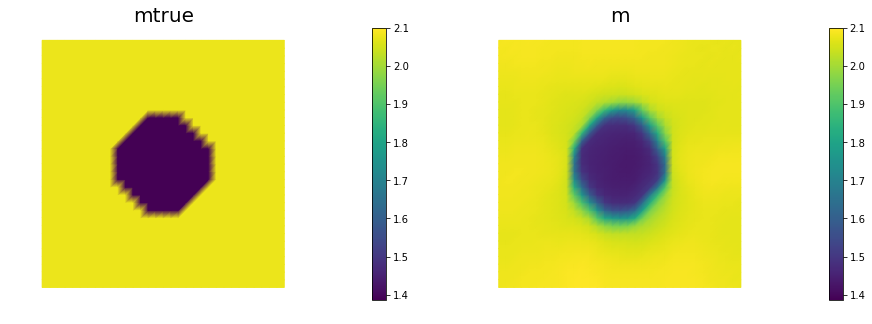

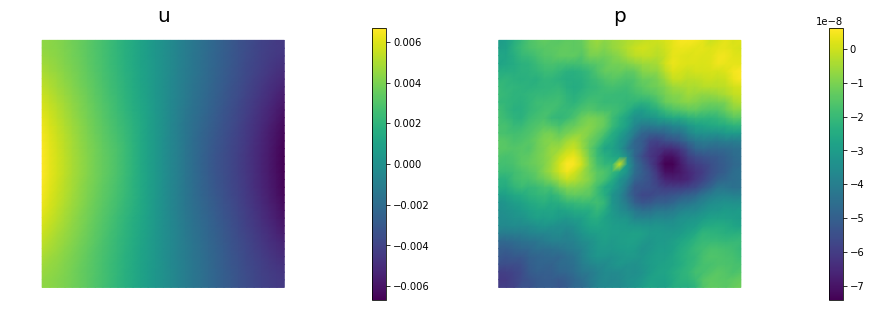

In [10]:
nb.multi1_plot([mtrue, m], ["mtrue", "m"])
nb.multi1_plot([u,p], ["u","p"], same_colorbar=False)
plt.show()

---

Copyright &copy; 2019, Washington University in St. Louis.

All Rights reserved.
See file COPYRIGHT for details.

This file is part of **cmis_labs**, the teaching material for the S2019 BME 493/593 course on *Computational Methods in Imaging Science* at Washington University in St. Louis. Please see [https://uvilla.github.io/cmis_labs](https://uvilla.github.io/cmis_labs) for more information and source code availability.

We would like to acknowledge the Extreme Science and Engineering Discovery Environment (XSEDE), which is supported by National Science Foundation grant number ACI-1548562, for providing cloud computing resources (Jetstream) for this course through allocation TG-SEE190001.